In [3]:
# 1
!nvidia-smi
import lightgbm as lgb
print('LightGBM version:', lgb.__version__)

Wed Jul 23 00:03:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 30%   35C    P0             28W /  285W |    1764MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# 2
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Common preprocessing & latest features (exp_04)
def preprocess(df):
    # ── Cabin から Deck／Side
    df['Deck'] = df['Cabin'].str[0].fillna('U').astype('category')
    df['Side'] = df['Cabin'].str[-1] \
        .map(lambda x: 'port' if x in ['P','L'] else 'starboard') \
        .fillna('U').astype('category')

    # ── PassengerId のグループサイズ（家族・同乗者数）を作成
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['IsSolo'] = (df['GroupSize'] == 1).astype(int)

    # ── 数値列の欠損補完
    for col in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    # ── もしくは HomePlanet／Destination／VIP／CryoSleep の欠損補完例
    df['HomePlanet']   = df['HomePlanet'].fillna('Unknown').astype('category')
    df['Destination']  = df['Destination'].fillna('Unknown').astype('category')
    df['VIP']          = df['VIP'].fillna(False).astype(int)
    df['CryoSleep']    = df['CryoSleep'].fillna(False).astype(int)

    return df


# Load data
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')
train = preprocess(train)
test  = preprocess(test)
TARGET = 'Transported'
features = [c for c in train.columns if c not in ['PassengerId', TARGET]]

/tmp/ipykernel_11213/1695228328.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP']          = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_11213/1695228328.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep']    = df['CryoSleep'].fillna(False).astype(int)
/tmp/ipykernel_11213/1695228328.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futur

In [5]:
# 3
from sklearn.model_selection import StratifiedGroupKFold
sgkf  = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups = train['PassengerId'].str.split('_').str[0].astype(int)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

In [6]:
# 4 モデル学習＆MLflowログ（CPUモード版）
import mlflow
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score

mlflow.set_experiment('exp_06_lgbm_sgk')
CONFIG = {
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
}
# カテゴリ型へ変換
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].astype('category')
    test[col]  = test[col].astype('category')

with mlflow.start_run(run_name='exp_06_lgbm_sgk'):
    for fold, (tr_idx, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
        print(f'Fold {fold}')
        tr_data = lgb.Dataset(train.iloc[tr_idx][features], label=train.iloc[tr_idx][TARGET], categorical_feature='auto')
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=train.iloc[val_idx][TARGET], categorical_feature='auto')
        model = lgb.train(CONFIG, tr_data, valid_sets=[val_data], callbacks=[early_stopping(50), log_evaluation(period=0)])
        oof_preds[val_idx] = (model.predict(train.iloc[val_idx][features]) > 0.5).astype(int)
        test_preds       += model.predict(test[features]) / sgkf.n_splits
    cv_acc = accuracy_score(train[TARGET], oof_preds)
    mlflow.log_metric('cv_acc', cv_acc)
    print(f'[exp_06_lgbm_sgk] cv_acc: {cv_acc:.4f}')

Fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.229228
Fold 1
[LightGBM] [Warning] Categorical features with more bins than the co

Fold 0 acc: 0.7708
Fold 1 acc: 0.8244
Fold 2 acc: 0.8075
Fold 3 acc: 0.8078
Fold 4 acc: 0.7894


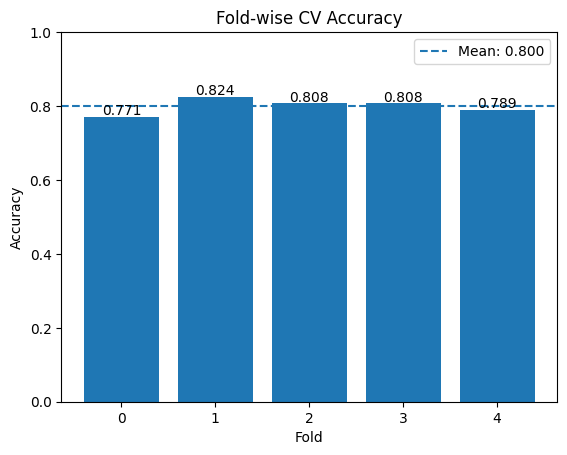

In [7]:
# 5 Fold-wise 可視化
import matplotlib.pyplot as plt
fold_scores = []
for fold, (_, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
    acc = accuracy_score(train.iloc[val_idx][TARGET], oof_preds[val_idx])
    fold_scores.append(acc)
    print(f'Fold {fold} acc: {acc:.4f}')
mean_score = np.mean(fold_scores)
plt.bar(range(len(fold_scores)), fold_scores)
plt.axhline(mean_score, linestyle='--', label=f'Mean: {mean_score:.3f}')
for i, s in enumerate(fold_scores): plt.text(i, s+0.005, f'{s:.3f}', ha='center')
plt.title('Fold-wise CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


In [8]:
# 6 最適閾値探索
from sklearn.metrics import accuracy_score
probs = np.zeros(len(train))
for fold, (tr_idx, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
    tr_data = lgb.Dataset(train.iloc[tr_idx][features], label=train.iloc[tr_idx][TARGET], categorical_feature='auto')
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=train.iloc[val_idx][TARGET], categorical_feature='auto')
    model_tmp = lgb.train(CONFIG, tr_data, valid_sets=[val_data], callbacks=[early_stopping(50), log_evaluation(period=0)])
    probs[val_idx] = model_tmp.predict(train.iloc[val_idx][features])
best_acc, best_thresh = 0, 0.5
for t in np.linspace(0.3, 0.7, 41):
    acc = accuracy_score(train[TARGET], (probs>t).astype(int))
    if acc > best_acc:
        best_acc, best_thresh = acc, t
print(f'Best threshold: {best_thresh:.2f}, CV acc: {best_acc:.4f}')


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.229228
[LightGBM] [Warning] Categorical features with more bins than the configured maxim

In [9]:
# 7 特徴量重要度下位10%除外して再学習
fi = pd.DataFrame({'feature': features, 'importance': model.feature_importance('gain')}).sort_values('importance')
low_feats = fi.head(int(len(features)*0.1))['feature'].tolist()
print('除外する特徴量:', low_feats)
features_excluded = [f for f in features if f not in low_feats]
oof_preds_ex = np.zeros(len(train))
test_preds_ex = np.zeros(len(test))
with mlflow.start_run(run_name='exp_06_feat_excluded'):
    for fold, (tr_idx, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
        tr_data = lgb.Dataset(train.iloc[tr_idx][features_excluded], label=train.iloc[tr_idx][TARGET], categorical_feature='auto')
        val_data = lgb.Dataset(train.iloc[val_idx][features_excluded], label=train.iloc[val_idx][TARGET], categorical_feature='auto')
        model_ex = lgb.train(CONFIG, tr_data, valid_sets=[val_data], callbacks=[early_stopping(50), log_evaluation(period=0)])
        oof_preds_ex[val_idx] = (model_ex.predict(train.iloc[val_idx][features_excluded])>0.5).astype(int)
        test_preds_ex       += model_ex.predict(test[features_excluded]) / sgkf.n_splits
    cv_acc_ex = accuracy_score(train[TARGET], oof_preds_ex)
    mlflow.log_metric('cv_acc_excluded', cv_acc_ex)
    print(f'[exp_06_feat_excluded] cv_acc_ex: {cv_acc_ex:.4f}')


除外する特徴量: ['Cabin']
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.230996
[LightGBM] [Warning] Categorical features with more bins than t

In [11]:
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'random_state': 42,
        'n_jobs': -1,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }
    oof = np.zeros(len(train))
    for tr_idx, val_idx in sgkf.split(train, train[TARGET], groups):
        dtrain = lgb.Dataset(
            train.iloc[tr_idx][features],
            label=train.iloc[tr_idx][TARGET],
            categorical_feature='auto'
        )
        dval = lgb.Dataset(
            train.iloc[val_idx][features],
            label=train.iloc[val_idx][TARGET],
            categorical_feature='auto'
        )
        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            callbacks=[
                early_stopping(stopping_rounds=50),  # 50 イテレーション改善がなければ停止
                log_evaluation(period=0)             # ログ出力を抑制
            ]
        )
        oof[val_idx] = model.predict(train.iloc[val_idx][features])
    return accuracy_score(train[TARGET], (oof > 0.5).astype(int))

# 実行例
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best trial params:', study.best_trial.params)
print('Best trial CV acc:', study.best_value)


[I 2025-07-23 00:04:25,523] A new study created in memory with name: no-name-0ba85507-9725-4ebc-a594-8568efa92f1b
/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_unifor

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_error: 0.231585
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categ

[I 2025-07-23 00:04:28,681] Trial 0 finished with value: 0.7951225123662717 and parameters: {'learning_rate': 0.0012322978719084454, 'num_leaves': 67, 'feature_fraction': 0.7845146674193633, 'bagging_fraction': 0.9713041050544267, 'bagging_freq': 10, 'min_child_samples': 15, 'lambda_l1': 3.333170423515792e-05, 'lambda_l2': 0.0033797529893926717}. Best is trial 0 with value: 0.7951225123662717.


Did not meet early stopping. Best iteration is:
[72]	valid_0's binary_error: 0.213408


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_error: 0.22746
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For catego

[I 2025-07-23 00:04:30,676] Trial 1 finished with value: 0.8030599332796503 and parameters: {'learning_rate': 0.03143709092359141, 'num_leaves': 19, 'feature_fraction': 0.7406012511309492, 'bagging_fraction': 0.822901620737329, 'bagging_freq': 6, 'min_child_samples': 13, 'lambda_l1': 4.289289931458659e-07, 'lambda_l2': 0.002848821362073592}. Best is trial 1 with value: 0.8030599332796503.


Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_error: 0.203352


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:04:32,036] Trial 2 finished with value: 0.7955826527090762 and parameters: {'learning_rate': 0.0028731259205208937, 'num_leaves': 73, 'feature_fraction': 0.6493570006169386, 'bagging_fraction': 0.8643708849619922, 'bagging_freq': 2, 'min_child_samples': 37, 'lambda_l1': 2.21517624005447e-07, 'lambda_l2': 5.96891744538604}. Best is trial 1 with value: 0.8030599332796503.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_error: 0.226871
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categ

[I 2025-07-23 00:04:35,391] Trial 3 finished with value: 0.8037501437938571 and parameters: {'learning_rate': 0.029418505990523855, 'num_leaves': 43, 'feature_fraction': 0.6908971300873321, 'bagging_fraction': 0.6273201456295071, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 3.177008371531067e-05, 'lambda_l2': 0.11121000676759983}. Best is trial 3 with value: 0.8037501437938571.


Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_error: 0.203911


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:04:38,415] Trial 4 finished with value: 0.8074312665362936 and parameters: {'learning_rate': 0.05088354518074494, 'num_leaves': 119, 'feature_fraction': 0.921957233938787, 'bagging_fraction': 0.7892136412707038, 'bagging_freq': 10, 'min_child_samples': 67, 'lambda_l1': 2.826841065893202e-05, 'lambda_l2': 7.343015770068418e-07}. Best is trial 4 with value: 0.8074312665362936.
/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction'

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:04:43,209] Trial 5 finished with value: 0.801104336822731 and parameters: {'learning_rate': 0.022720495302570653, 'num_leaves': 98, 'feature_fraction': 0.6524164624424459, 'bagging_fraction': 0.7269599671469549, 'bagging_freq': 9, 'min_child_samples': 22, 'lambda_l1': 0.17142862061611225, 'lambda_l2': 0.012925607413262541}. Best is trial 4 with value: 0.8074312665362936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_error: 0.206704


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:04:53,889] Trial 6 finished with value: 0.8025997929368457 and parameters: {'learning_rate': 0.02435000441915982, 'num_leaves': 121, 'feature_fraction': 0.7554124764498034, 'bagging_fraction': 0.6318968887830013, 'bagging_freq': 6, 'min_child_samples': 24, 'lambda_l1': 9.964631057949062e-08, 'lambda_l2': 1.1128180122995512e-06}. Best is trial 4 with value: 0.8074312665362936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.205587


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.218032
[LightGBM] [Warning] Categorical features with more bins than the co

[I 2025-07-23 00:04:57,641] Trial 7 finished with value: 0.8078914068790981 and parameters: {'learning_rate': 0.05893737483456558, 'num_leaves': 19, 'feature_fraction': 0.7387929693580491, 'bagging_fraction': 0.6869796232596056, 'bagging_freq': 6, 'min_child_samples': 90, 'lambda_l1': 0.001233243880301426, 'lambda_l2': 1.5067955067959493e-08}. Best is trial 7 with value: 0.8078914068790981.


Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_error: 0.201676


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:00,666] Trial 8 finished with value: 0.8021396525940412 and parameters: {'learning_rate': 0.023412916370387227, 'num_leaves': 108, 'feature_fraction': 0.6714326394899, 'bagging_fraction': 0.9936539918072791, 'bagging_freq': 9, 'min_child_samples': 52, 'lambda_l1': 5.384853723941771e-06, 'lambda_l2': 1.020768070918495e-07}. Best is trial 7 with value: 0.8078914068790981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:03,826] Trial 9 finished with value: 0.7974232140802945 and parameters: {'learning_rate': 0.021419096014535382, 'num_leaves': 107, 'feature_fraction': 0.6493973837013287, 'bagging_fraction': 0.9768810453837546, 'bagging_freq': 1, 'min_child_samples': 99, 'lambda_l1': 9.023713377814948e-06, 'lambda_l2': 6.792605719852515}. Best is trial 7 with value: 0.8078914068790981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_error: 0.213318
[LightGBM] [Warning] Categorical features with more bins than the con

[I 2025-07-23 00:05:06,364] Trial 10 finished with value: 0.8081214770505004 and parameters: {'learning_rate': 0.09941349026643642, 'num_leaves': 16, 'feature_fraction': 0.8865190790381097, 'bagging_fraction': 0.7074855715039958, 'bagging_freq': 4, 'min_child_samples': 95, 'lambda_l1': 0.08145987909744275, 'lambda_l2': 1.3074961526361369e-05}. Best is trial 10 with value: 0.8081214770505004.


Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_error: 0.202793


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_error: 0.218621
[LightGBM] [Warning] Categorical features with more bins than the con

[I 2025-07-23 00:05:08,173] Trial 11 finished with value: 0.8080064419647993 and parameters: {'learning_rate': 0.09199254951691516, 'num_leaves': 16, 'feature_fraction': 0.885358926987483, 'bagging_fraction': 0.71683589313607, 'bagging_freq': 4, 'min_child_samples': 94, 'lambda_l1': 0.023373605205849694, 'lambda_l2': 3.0451053834309495e-05}. Best is trial 10 with value: 0.8081214770505004.


Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_error: 0.201676


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:16,144] Trial 12 finished with value: 0.8073162314505924 and parameters: {'learning_rate': 0.08469733775634686, 'num_leaves': 41, 'feature_fraction': 0.8867600289314586, 'bagging_fraction': 0.7198574423455836, 'bagging_freq': 4, 'min_child_samples': 80, 'lambda_l1': 3.8055694728630263, 'lambda_l2': 1.7501669666531762e-05}. Best is trial 10 with value: 0.8081214770505004.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_error: 0.236299
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical featur

[I 2025-07-23 00:05:14,066] Trial 13 finished with value: 0.7942022316806626 and parameters: {'learning_rate': 0.00729112378538689, 'num_leaves': 38, 'feature_fraction': 0.9906800378174632, 'bagging_fraction': 0.7781852515247527, 'bagging_freq': 4, 'min_child_samples': 73, 'lambda_l1': 0.009331276544028608, 'lambda_l2': 5.2874585457240964e-05}. Best is trial 10 with value: 0.8081214770505004.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.212291


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.239835
[LightGBM] [Warning] Categorical features with more bins than the configured maxim

[I 2025-07-23 00:05:15,417] Trial 14 finished with value: 0.7921316001380421 and parameters: {'learning_rate': 0.008498606890613873, 'num_leaves': 16, 'feature_fraction': 0.8696618662763337, 'bagging_fraction': 0.6840412375212083, 'bagging_freq': 3, 'min_child_samples': 99, 'lambda_l1': 0.08306700845185087, 'lambda_l2': 5.3939983314874864e-05}. Best is trial 10 with value: 0.8081214770505004.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.196943
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3469, number of negative: 3434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 6903, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502535 -> initscore=0.010141
[LightGBM] [Info] Start training from score 0.010141
Training until validation scores don't improve for 50 rounds
Early stopping, best 

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:17,001] Trial 15 finished with value: 0.8100770735074198 and parameters: {'learning_rate': 0.09935341024056224, 'num_leaves': 58, 'feature_fraction': 0.8314031170831682, 'bagging_fraction': 0.8811499103561635, 'bagging_freq': 7, 'min_child_samples': 58, 'lambda_l1': 3.1202204601862973, 'lambda_l2': 3.8327060177492945e-06}. Best is trial 15 with value: 0.8100770735074198.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:19,930] Trial 16 finished with value: 0.8039802139652594 and parameters: {'learning_rate': 0.0518071234135968, 'num_leaves': 66, 'feature_fraction': 0.8283077082395508, 'bagging_fraction': 0.8965336544461253, 'bagging_freq': 8, 'min_child_samples': 56, 'lambda_l1': 7.942132198615493, 'lambda_l2': 1.9142453725750694e-06}. Best is trial 15 with value: 0.8100770735074198.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:05:22,570] Trial 17 finished with value: 0.792016565052341 and parameters: {'learning_rate': 0.004527814803853027, 'num_leaves': 85, 'feature_fraction': 0.9646519775912559, 'bagging_fraction': 0.9197723246729093, 'bagging_freq': 7, 'min_child_samples': 46, 'lambda_l1': 1.1583992894159805, 'lambda_l2': 0.00045777069820876026}. Best is trial 15 with value: 0.8100770735074198.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:24,760] Trial 18 finished with value: 0.7989186701944093 and parameters: {'learning_rate': 0.013819142536324254, 'num_leaves': 50, 'feature_fraction': 0.8420709504865873, 'bagging_fraction': 0.842768167449119, 'bagging_freq': 7, 'min_child_samples': 83, 'lambda_l1': 0.4878543376091667, 'lambda_l2': 6.482792258197714e-06}. Best is trial 15 with value: 0.8100770735074198.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_error: 0.2

[I 2025-07-23 00:05:26,476] Trial 19 finished with value: 0.8065109858506845 and parameters: {'learning_rate': 0.09722759256788165, 'num_leaves': 53, 'feature_fraction': 0.9336410606762302, 'bagging_fraction': 0.7652905800878138, 'bagging_freq': 5, 'min_child_samples': 67, 'lambda_l1': 0.000875854196445815, 'lambda_l2': 1.5967616432981996e-07}. Best is trial 15 with value: 0.8100770735074198.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.202793


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.226871
[LightGBM] [Warning] Categorical features with more bins than the configured maxim

[I 2025-07-23 00:05:28,877] Trial 20 finished with value: 0.8039802139652594 and parameters: {'learning_rate': 0.04644173633799425, 'num_leaves': 32, 'feature_fraction': 0.8104695040044625, 'bagging_fraction': 0.927863491665977, 'bagging_freq': 2, 'min_child_samples': 33, 'lambda_l1': 0.007085492003318661, 'lambda_l2': 0.00015429713846985582}. Best is trial 15 with value: 0.8100770735074198.


Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_error: 0.206704


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_error: 0.212139
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categ

[I 2025-07-23 00:05:30,727] Trial 21 finished with value: 0.8106522489359255 and parameters: {'learning_rate': 0.09725044733444409, 'num_leaves': 29, 'feature_fraction': 0.8857126219094053, 'bagging_fraction': 0.7444780973650492, 'bagging_freq': 5, 'min_child_samples': 89, 'lambda_l1': 0.037103541204519565, 'lambda_l2': 7.157639256308277e-06}. Best is trial 21 with value: 0.8106522489359255.


Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_error: 0.200559


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's binary_error: 0.215675
[LightGBM] [Warning] Categorical features with more bins than the con

[I 2025-07-23 00:05:32,618] Trial 22 finished with value: 0.807776371793397 and parameters: {'learning_rate': 0.07050426412717367, 'num_leaves': 30, 'feature_fraction': 0.8561385888200167, 'bagging_fraction': 0.7544956954176539, 'bagging_freq': 5, 'min_child_samples': 83, 'lambda_l1': 0.0635285280428067, 'lambda_l2': 3.5943114410323104e-06}. Best is trial 21 with value: 0.8106522489359255.


Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_error: 0.188125
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3469, number of negative: 3434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 6903, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502535 -> initscore=0.010141
[LightGBM] [Info] Start training from score 0.010141
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_error: 0.2198
[LightGBM] [Warning] Categorical features with more bins than the confi

[I 2025-07-23 00:05:34,521] Trial 23 finished with value: 0.8063959507649833 and parameters: {'learning_rate': 0.046746768296811306, 'num_leaves': 28, 'feature_fraction': 0.9137988190444102, 'bagging_fraction': 0.6676755986018453, 'bagging_freq': 7, 'min_child_samples': 61, 'lambda_l1': 1.0228107769445123, 'lambda_l2': 2.0711665147475868e-07}. Best is trial 21 with value: 0.8106522489359255.
/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction'

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:05:36,118] Trial 24 finished with value: 0.8045553893937651 and parameters: {'learning_rate': 0.035120476975250184, 'num_leaves': 54, 'feature_fraction': 0.7882214586461538, 'bagging_fraction': 0.6002592526495778, 'bagging_freq': 5, 'min_child_samples': 90, 'lambda_l1': 0.0036832702579260588, 'lambda_l2': 0.0004956590730332754}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:38,576] Trial 25 finished with value: 0.8100770735074198 and parameters: {'learning_rate': 0.09801155935760233, 'num_leaves': 61, 'feature_fraction': 0.9484284001750413, 'bagging_fraction': 0.8666300150712382, 'bagging_freq': 3, 'min_child_samples': 79, 'lambda_l1': 0.2833661216810178, 'lambda_l2': 1.6034004582897827e-08}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[43]	valid_0's binary_error: 0.199441


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:41,095] Trial 26 finished with value: 0.8074312665362936 and parameters: {'learning_rate': 0.06936058236532303, 'num_leaves': 82, 'feature_fraction': 0.9568932175231462, 'bagging_fraction': 0.8681784253076937, 'bagging_freq': 3, 'min_child_samples': 75, 'lambda_l1': 2.6559874302302844, 'lambda_l2': 3.1073388952687126e-08}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.233942
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical featur

[I 2025-07-23 00:05:44,377] Trial 27 finished with value: 0.7966179684803865 and parameters: {'learning_rate': 0.014578044693901273, 'num_leaves': 59, 'feature_fraction': 0.9969514503109921, 'bagging_fraction': 0.8149380914960749, 'bagging_freq': 8, 'min_child_samples': 46, 'lambda_l1': 1.012825574532808e-08, 'lambda_l2': 4.89081473310231e-07}. Best is trial 21 with value: 0.8106522489359255.


Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.213408


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:05:56,133] Trial 28 finished with value: 0.805245599907972 and parameters: {'learning_rate': 0.03959519477321229, 'num_leaves': 84, 'feature_fraction': 0.9547404689718092, 'bagging_fraction': 0.8880245171176121, 'bagging_freq': 3, 'min_child_samples': 68, 'lambda_l1': 0.3387336836725645, 'lambda_l2': 1.0151827683614666e-08}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_error: 0.202793


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:05:52,313] Trial 29 finished with value: 0.7921316001380421 and parameters: {'learning_rate': 0.0013970338349522187, 'num_leaves': 67, 'feature_fraction': 0.8232691960482226, 'bagging_fraction': 0.9314590902445657, 'bagging_freq': 2, 'min_child_samples': 60, 'lambda_l1': 9.382737016709598, 'lambda_l2': 4.179878945983883e-08}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_error: 0.220389
[LightGBM] [Warning] Categorical features with more bins than the con

[I 2025-07-23 00:05:54,717] Trial 30 finished with value: 0.8067410560220868 and parameters: {'learning_rate': 0.07102942966666995, 'num_leaves': 46, 'feature_fraction': 0.8974212082736874, 'bagging_fraction': 0.8346650753823299, 'bagging_freq': 1, 'min_child_samples': 79, 'lambda_l1': 0.0001520077394521362, 'lambda_l2': 0.0016319992155276117}. Best is trial 21 with value: 0.8106522489359255.


Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_error: 0.200559


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:05:59,003] Trial 31 finished with value: 0.8091567928218106 and parameters: {'learning_rate': 0.09749587619281777, 'num_leaves': 61, 'feature_fraction': 0.8503607751863744, 'bagging_fraction': 0.7449611217131961, 'bagging_freq': 5, 'min_child_samples': 87, 'lambda_l1': 0.04657704895902425, 'lambda_l2': 1.1208341391721662e-05}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:06,329] Trial 32 finished with value: 0.8068560911077879 and parameters: {'learning_rate': 0.07025864801871115, 'num_leaves': 74, 'feature_fraction': 0.6006897043276472, 'bagging_fraction': 0.8010024659239314, 'bagging_freq': 6, 'min_child_samples': 88, 'lambda_l1': 0.02874428000004037, 'lambda_l2': 4.246924190803855e-06}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:07,300] Trial 33 finished with value: 0.8070861612791902 and parameters: {'learning_rate': 0.09921835194029056, 'num_leaves': 60, 'feature_fraction': 0.7720241185197962, 'bagging_fraction': 0.7526728333139976, 'bagging_freq': 5, 'min_child_samples': 75, 'lambda_l1': 0.41425104029800375, 'lambda_l2': 9.320606059440108e-05}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_error: 0.194413


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:06:14,101] Trial 34 finished with value: 0.8088116875647072 and parameters: {'learning_rate': 0.05919943286924147, 'num_leaves': 65, 'feature_fraction': 0.8605121702812086, 'bagging_fraction': 0.8533596954402195, 'bagging_freq': 7, 'min_child_samples': 87, 'lambda_l1': 1.342440020907761, 'lambda_l2': 0.3531930627925482}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[54]	valid_0's binary_error: 0.200559


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:20,645] Trial 35 finished with value: 0.8046704244794662 and parameters: {'learning_rate': 0.03603759467541843, 'num_leaves': 75, 'feature_fraction': 0.9313417470802132, 'bagging_fraction': 0.9524992105669319, 'bagging_freq': 8, 'min_child_samples': 72, 'lambda_l1': 0.018906721550930792, 'lambda_l2': 4.4998082740080815e-07}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_error: 0.207263


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_error: 0.229228
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categ

[I 2025-07-23 00:06:22,668] Trial 36 finished with value: 0.7967330035660877 and parameters: {'learning_rate': 0.0015843340382426755, 'num_leaves': 57, 'feature_fraction': 0.8055325313431687, 'bagging_fraction': 0.8864230706716804, 'bagging_freq': 6, 'min_child_samples': 37, 'lambda_l1': 0.0021360884635476802, 'lambda_l2': 0.005369277464078391}. Best is trial 21 with value: 0.8106522489359255.


Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.213408


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_error: 0.216853
[LightGBM] [Warning] Categorical features with more bins than the con

[I 2025-07-23 00:06:27,422] Trial 37 finished with value: 0.8058207753364777 and parameters: {'learning_rate': 0.07470354807984626, 'num_leaves': 48, 'feature_fraction': 0.906340082006114, 'bagging_fraction': 0.808178175854567, 'bagging_freq': 3, 'min_child_samples': 8, 'lambda_l1': 0.15147864899806412, 'lambda_l2': 1.8063140455321533e-06}. Best is trial 21 with value: 0.8106522489359255.


Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_error: 0.203911


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:33,242] Trial 38 finished with value: 0.8068560911077879 and parameters: {'learning_rate': 0.03029112274013991, 'num_leaves': 95, 'feature_fraction': 0.709304081555667, 'bagging_fraction': 0.7437342214853231, 'bagging_freq': 5, 'min_child_samples': 64, 'lambda_l1': 0.00037372970063536575, 'lambda_l2': 0.02815785140877266}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_error: 0.199441


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:38,718] Trial 39 finished with value: 0.8086966524790061 and parameters: {'learning_rate': 0.05503344765427594, 'num_leaves': 35, 'feature_fraction': 0.8413817452045296, 'bagging_fraction': 0.7817258965997123, 'bagging_freq': 2, 'min_child_samples': 93, 'lambda_l1': 0.26002588653097114, 'lambda_l2': 1.4076574934099295e-05}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_error: 0.198883


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:42,710] Trial 40 finished with value: 0.7946623720234671 and parameters: {'learning_rate': 0.002163510281644491, 'num_leaves': 23, 'feature_fraction': 0.7738514944979292, 'bagging_fraction': 0.868822141791598, 'bagging_freq': 9, 'min_child_samples': 83, 'lambda_l1': 2.7789074591673746, 'lambda_l2': 0.00023213788359743913}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.211732


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:46,157] Trial 41 finished with value: 0.8076613367076958 and parameters: {'learning_rate': 0.061490470496921495, 'num_leaves': 61, 'feature_fraction': 0.863575241083303, 'bagging_fraction': 0.8499607413105887, 'bagging_freq': 7, 'min_child_samples': 87, 'lambda_l1': 1.6983361501424634, 'lambda_l2': 0.0834504474134246}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:51,418] Trial 42 finished with value: 0.8085816173933049 and parameters: {'learning_rate': 0.08313983319637211, 'num_leaves': 64, 'feature_fraction': 0.8536132804507471, 'bagging_fraction': 0.8273923101644312, 'bagging_freq': 7, 'min_child_samples': 100, 'lambda_l1': 0.7086081580172425, 'lambda_l2': 0.37366769916750003}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:06:55,558] Trial 43 finished with value: 0.8061658805935811 and parameters: {'learning_rate': 0.042906501766284355, 'num_leaves': 79, 'feature_fraction': 0.8729302873719624, 'bagging_fraction': 0.9118270705519592, 'bagging_freq': 6, 'min_child_samples': 78, 'lambda_l1': 0.048302826237643516, 'lambda_l2': 1.30054514088685}. Best is trial 21 with value: 0.8106522489359255.
/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:06:58,965] Trial 44 finished with value: 0.807776371793397 and parameters: {'learning_rate': 0.06272617409114274, 'num_leaves': 69, 'feature_fraction': 0.8317560427350961, 'bagging_fraction': 0.8535436215635189, 'bagging_freq': 6, 'min_child_samples': 86, 'lambda_l1': 0.12518849903310064, 'lambda_l2': 6.025260081254956e-08}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:07:01,093] Trial 45 finished with value: 0.8090417577361095 and parameters: {'learning_rate': 0.0869732254010705, 'num_leaves': 92, 'feature_fraction': 0.9401937512824728, 'bagging_fraction': 0.7366434140777876, 'bagging_freq': 8, 'min_child_samples': 91, 'lambda_l1': 4.551854130447312, 'lambda_l2': 0.0012044733120744376}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_error: 0.201676


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:07:03,023] Trial 46 finished with value: 0.8091567928218106 and parameters: {'learning_rate': 0.08530202685942631, 'num_leaves': 91, 'feature_fraction': 0.9404513507428559, 'bagging_fraction': 0.7319634339131332, 'bagging_freq': 10, 'min_child_samples': 94, 'lambda_l1': 4.662426045268779, 'lambda_l2': 0.0018946112137678767}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:07:08,376] Trial 47 finished with value: 0.8090417577361095 and parameters: {'learning_rate': 0.08014924578583166, 'num_leaves': 104, 'feature_fraction': 0.9649401821440513, 'bagging_fraction': 0.6847460919525721, 'bagging_freq': 10, 'min_child_samples': 96, 'lambda_l1': 1.1469420922076215e-06, 'lambda_l2': 0.007001344977705968}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[51]	valid_0's binary_error: 0.198324


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-23 00:07:16,271] Trial 48 finished with value: 0.7901760036811227 and parameters: {'learning_rate': 0.004669830884628527, 'num_leaves': 89, 'feature_fraction': 0.9139407226811019, 'bagging_fraction': 0.7022650857138095, 'bagging_freq': 9, 'min_child_samples': 95, 'lambda_l1': 0.008350700726054386, 'lambda_l2': 7.905858995232768e-07}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.213408


/tmp/ipykernel_11213/3730538032.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/tmp/ipykernel_11213/3730538032.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
/tmp/ipykernel_11213/3730538032.py:15: FutureWarning: suggest_loguniform has been

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-07-23 00:07:14,889] Trial 49 finished with value: 0.8037501437938571 and parameters: {'learning_rate': 0.09983101667646416, 'num_leaves': 118, 'feature_fraction': 0.9801239682042406, 'bagging_fraction': 0.7729785970273664, 'bagging_freq': 4, 'min_child_samples': 52, 'lambda_l1': 9.121747878606426, 'lambda_l2': 3.652937395244984e-05}. Best is trial 21 with value: 0.8106522489359255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f